In [26]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use("seaborn-v0_8")


##### 5) You are to present a case for operating a Battery Energy Storage System. The battery charges/discharges 1MW at 100% efficiency and has a 2MWh storage capacity. Using your freshly designed DA price model, build an algorithmic strategy for the battery, aiming to maximize the PnL generated over 2025 through the Day-Ahead market. Then using the real DA price, simulate and backtest your strategy to get the real PnL.

In [27]:
forecast_2025 = pd.read_csv("../data/romania_da_price_forecast_2025.csv",
    parse_dates=["timestamp"]
)
forecast_2025= forecast_2025.set_index("timestamp")

In [28]:
forecast_2025.head()

,predicted_price_eur_mwh
timestamp,
2025-01-01 00:00:00+00:00,129.534400
2025-01-01 01:00:00+00:00,121.148994
2025-01-01 02:00:00+00:00,116.154060
2025-01-01 03:00:00+00:00,86.747610
2025-01-01 04:00:00+00:00,71.848145


In [29]:
forecast_2025.round(2)

,predicted_price_eur_mwh
timestamp,
2025-01-01 00:00:00+00:00,129.53
2025-01-01 01:00:00+00:00,121.15
2025-01-01 02:00:00+00:00,116.15
2025-01-01 03:00:00+00:00,86.75
2025-01-01 04:00:00+00:00,71.85
...,...
2025-12-31 19:00:00+00:00,109.63
2025-12-31 20:00:00+00:00,103.46
2025-12-31 21:00:00+00:00,102.44


In [30]:
filter_2025 = pd.read_csv("../data/processed_data/data_da_price.csv",
    parse_dates=["Timestamp"]
)
filter_2025 = filter_2025.set_index("Timestamp")

In [31]:
# Keep only 2025 data
filter_2025 = filter_2025[filter_2025.index.year == 2025]

In [32]:
filter_2025 = filter_2025[["target"]]

In [33]:
filter_2025.head()

,target
Timestamp,
2025-01-01 00:00:00+00:00,134.06
2025-01-01 01:00:00+00:00,124.42
2025-01-01 02:00:00+00:00,84.48
2025-01-01 03:00:00+00:00,64.28
2025-01-01 04:00:00+00:00,66.70


In [34]:
assert forecast_2025.index.inferred_freq in ["H", "h"], forecast_2025.index.inferred_freq
assert filter_2025.index.inferred_freq in ["H", "h"], filter_2025.index.inferred_freq


##### For each day, the algorithm identifies the single best charge and discharge hours that maximize the forecasted intraday price spread.
##### The battery is allowed to perform at most one charge–discharge cycle per day, subject to power and state-of-charge constraints.
##### The resulting schedule is then executed on real day-ahead prices to evaluate the actual PnL.

In [35]:
# BESS PARAMETERS
BATTERY_CAPACITY_MWh = 2.0   # Maximum energy stored
POWER_MW = 1.0              # Max charge / discharge per hour
EFFICIENCY = 1.0            # 100% efficiency (simplifying assumption)

In [36]:
# Strategy base on daily price forecast :
# One charge and one discharge per day

def best_buy_sell_pair(prices: np.ndarray):
    """
    prices: array shape (24,) forecast prices for the day
    Returns (buy_idx, sell_idx, best_spread)
    Tie-break:
      - earliest buy hour
      - earliest sell hour
    """
    best_spread = -np.inf
    best_buy = None
    best_sell = None
    
    # brute force over all pairs (24*24 is tiny)
    for buy in range(24):
        for sell in range(buy + 1, 24):
            spread = prices[sell] - prices[buy]
            if spread > best_spread:
                best_spread = spread
                best_buy, best_sell = buy, sell
            elif spread == best_spread:
                # tie-break: earliest buy, then earliest sell
                if buy < best_buy or (buy == best_buy and sell < best_sell):
                    best_buy, best_sell = buy, sell

    return best_buy, best_sell, best_spread


def build_daily_plan_option(forecast_day: pd.DataFrame):
    """
    forecast_day: DataFrame for one day with 24 hourly rows.
    Returns: dict with buy_ts, sell_ts if profitable, else None
    """
    prices = forecast_day["predicted_price_eur_mwh"].to_numpy()
    buy_i, sell_i, spread = best_buy_sell_pair(prices)
    
    # If no positive spread, do nothing 
    if spread <= 0:
        return None
    
    buy_ts = forecast_day.index[buy_i]
    sell_ts = forecast_day.index[sell_i]
    return {"buy_ts": buy_ts, "sell_ts": sell_ts, "spread_forecast": spread}

# Build plan for all days
plans = []

for day, df_day in forecast_2025.groupby(forecast_2025.index.date):
    df_day = df_day.sort_index()
    plan = build_daily_plan_option(df_day)
    if plan is not None:
        plans.append(plan)

plans_df = pd.DataFrame(plans).sort_values("buy_ts").reset_index(drop=True)
plans_df.head()


,buy_ts,sell_ts,spread_forecast
0,2025-01-01 10:00:00+00:00,2025-01-01 16:00:00+00:00,122.242492
1,2025-01-02 03:00:00+00:00,2025-01-02 17:00:00+00:00,122.935440
2,2025-01-03 02:00:00+00:00,2025-01-03 16:00:00+00:00,85.030930
3,2025-01-04 02:00:00+00:00,2025-01-04 16:00:00+00:00,105.350700
4,2025-01-05 05:00:00+00:00,2025-01-05 16:00:00+00:00,127.148266


In [37]:
actions = pd.Series(0.0, index=forecast_2025.index, name="action_mw")

for _, r in plans_df.iterrows():
    actions.loc[r["buy_ts"]] += POWER_MW     # charge
    actions.loc[r["sell_ts"]] -= POWER_MW    # discharge


In [ ]:
soc = 0.0
soc_series = []
exec_action = []  # action really executed after constraints

for ts in actions.index:
    a = actions.loc[ts]  # desired action
    
    if a > 0:  # charge
        max_charge = min(POWER_MW, BATTERY_CAPACITY_MWh - soc)
        a_exec = max_charge
        soc += a_exec * EFFICIENCY  # *1h implicit
    elif a < 0:  # discharge
        max_discharge = min(POWER_MW, soc)   # can't go below 0
        a_exec = -max_discharge
        soc += a_exec / EFFICIENCY  # negative, *1h implicit
    else:
        a_exec = 0.0
    
    soc_series.append(soc)
    exec_action.append(a_exec)

soc_series = pd.Series(soc_series, index=actions.index, name="soc_mwh")
exec_action = pd.Series(exec_action, index=actions.index, name="exec_action_mw")


In [39]:
df_bt = pd.DataFrame({
    "exec_action_mw": exec_action,
    "soc_mwh": soc_series,
}).join(filter_2025[["target"]], how="inner")

df_bt["pnl_eur"] = - df_bt["exec_action_mw"] * df_bt["target"]  # Remind 1h => MWh

total_pnl = df_bt["pnl_eur"].sum()
total_pnl


np.float64(50923.055)

In [40]:
df_bt["cum_pnl_eur"] = df_bt["pnl_eur"].cumsum()

In [41]:
df_bt.head(24)

,exec_action_mw,soc_mwh,target,pnl_eur,cum_pnl_eur
timestamp,,,,,
2025-01-01 00:00:00+00:00,0.0,0.0,134.06,-0.00,-0.00
2025-01-01 01:00:00+00:00,0.0,0.0,124.42,-0.00,-0.00
2025-01-01 02:00:00+00:00,0.0,0.0,84.48,-0.00,-0.00
2025-01-01 03:00:00+00:00,0.0,0.0,64.28,-0.00,-0.00
2025-01-01 04:00:00+00:00,0.0,0.0,66.70,-0.00,-0.00
2025-01-01 05:00:00+00:00,0.0,0.0,62.42,-0.00,-0.00
2025-01-01 06:00:00+00:00,0.0,0.0,56.78,-0.00,-0.00
2025-01-01 07:00:00+00:00,0.0,0.0,29.22,-0.00,-0.00
2025-01-01 08:00:00+00:00,0.0,0.0,41.43,-0.00,-0.00


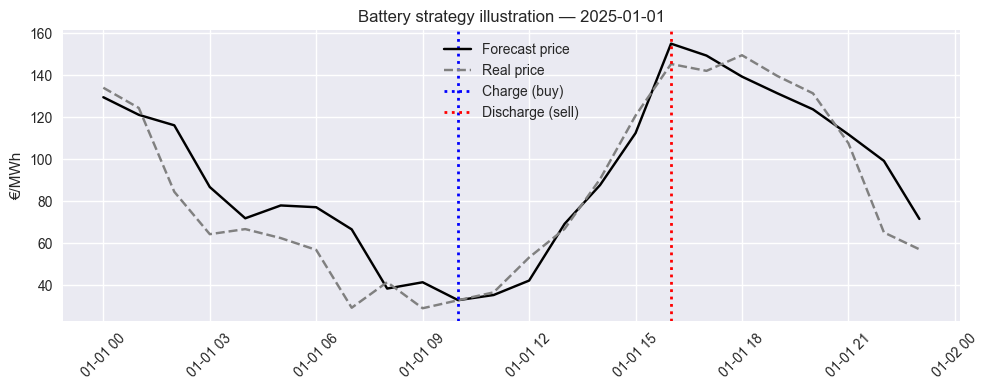

In [51]:
# --- Pick one example day (first trade day) ---
example_buy = plans_df.loc[0, "buy_ts"]
example_day = pd.Timestamp(example_buy).normalize()

day_fc = forecast_2025.loc[example_day: example_day + pd.Timedelta(hours=23)]
day_real = filter_2025.loc[example_day: example_day + pd.Timedelta(hours=23)]

buy_ts  = plans_df.loc[0, "buy_ts"]
sell_ts = plans_df.loc[0, "sell_ts"]

plt.figure(figsize=(10,4))

# Prices
plt.plot(
    day_fc.index,
    day_fc["predicted_price_eur_mwh"],
    label="Forecast price",
    color="black"
)

plt.plot(
    day_real.index,
    day_real["target"],
    label="Real price",
    linestyle="--",
    color="grey"
)

# Charge / Discharge markers
plt.axvline(
    buy_ts,
    color="blue",
    linestyle=":",
    linewidth=2,
    label="Charge (buy)"
)

plt.axvline(
    sell_ts,
    color="red",
    linestyle=":",
    linewidth=2,
    label="Discharge (sell)"
)


plt.title(f"Battery strategy illustration — {example_day.date()}")
plt.ylabel("€/MWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



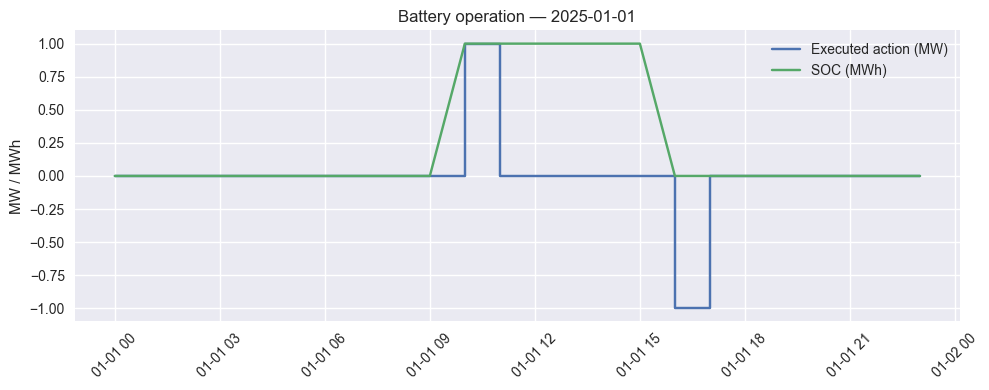

In [50]:
day_bt = df_bt.loc[example_day: example_day + pd.Timedelta(hours=23)]

plt.figure(figsize=(10,4))
plt.step(day_bt.index, day_bt["exec_action_mw"], where="post", label="Executed action (MW)")
plt.plot(day_bt.index, day_bt["soc_mwh"], label="SOC (MWh)")
plt.title(f"Battery operation — {example_day.date()}")
plt.ylabel("MW / MWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


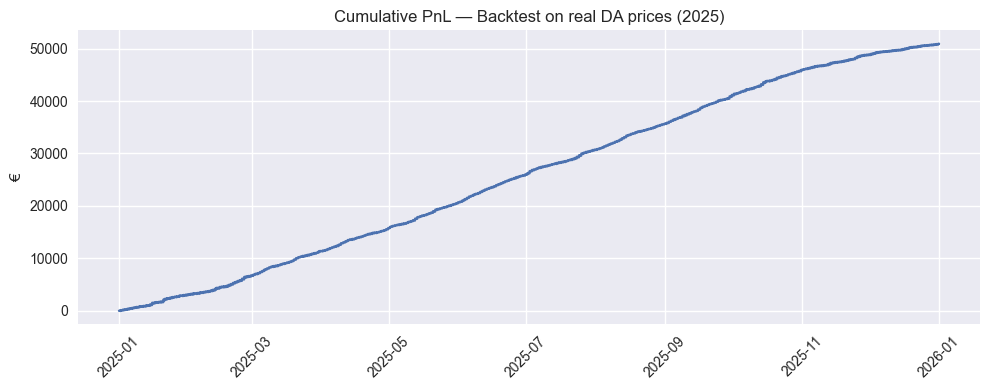

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df_bt.index, df_bt["cum_pnl_eur"])
plt.title("Cumulative PnL — Backtest on real DA prices (2025)")
plt.ylabel("€")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
